In [21]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
from rasterio.plot import reshape_as_raster, reshape_as_image

## Loading Data

In [22]:
nm_shp = gpd.read_file("nm.shp")
m_shp = gpd.read_file("m.shp")

nm_geoms = nm_shp.geometry
m_geoms = m_shp.geometry

In [24]:
src = rasterio.open("JamaicaFeaturesNoSAR+DTMresampled.tif")
mask_src = rasterio.open("maskdtmresampled.tif")
m_image, m_transform = mask(src, m_geoms, crop=True)
nm_image, nm_transform = mask(src, nm_geoms, crop=True)

#Getting mask for each class
mmask, mmask_transform = mask(mask_src, m_geoms, crop=True)
nmmask, nmmask_transform = mask(mask_src, nm_geoms, crop=True)

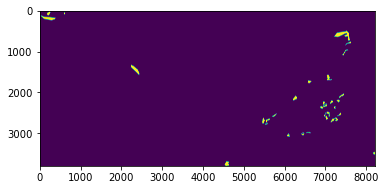

<AxesSubplot:>

In [35]:
from rasterio.plot import show
show(mmask)

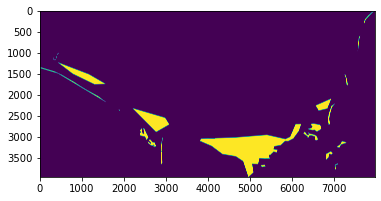

<AxesSubplot:>

In [36]:
show(nmmask)

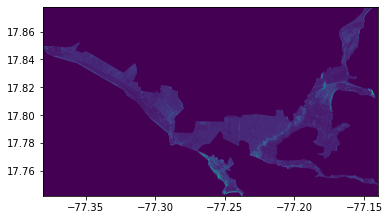

<AxesSubplot:>

In [37]:
show(src)

# Reshaping Data

In [38]:
m_idx = np.squeeze(((reshape_as_image(mmask) == 1)), axis=-1)
nm_idx = np.squeeze((reshape_as_image(nmmask) == 1), axis=-1)

In [39]:
m_pix = reshape_as_image(m_image)[m_idx]
nm_pix = reshape_as_image(nm_image)[nm_idx]

m_pix = m_pix[np.all(m_pix != 0, axis=1)]
nm_pix = nm_pix[np.all(nm_pix != 0, axis=1)]

In [40]:
x = np.concatenate((m_pix, nm_pix), axis = 0)
y = np.concatenate((np.zeros((m_pix.shape[0]))+1, np.zeros((nm_pix.shape[0]))))

In [41]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# Extremely Randomized Trees Training 

In [42]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
clf = ExtraTreesClassifier(n_jobs=4)

In [43]:
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

# Model Performance - ERT

In [44]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    256263
         1.0       1.00      1.00      1.00     35899

    accuracy                           1.00    292162
   macro avg       1.00      1.00      1.00    292162
weighted avg       1.00      1.00      1.00    292162



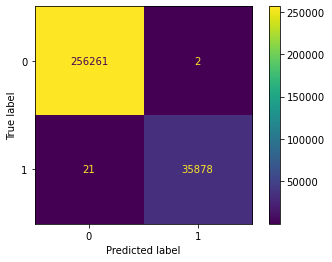

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [45]:
img = reshape_as_image(src.read())
array = img.reshape(img.shape[0] * img.shape[1], img.shape[2])

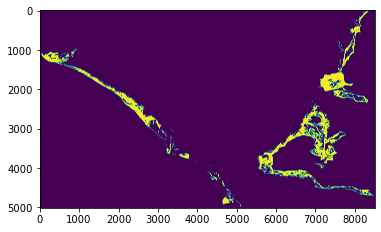

<AxesSubplot:>

In [46]:
output = clf.predict(array)
output_img = output.reshape(img.shape[0], img.shape[1], 1)
show(output_img)

In [47]:
out_meta = src.meta.copy()
out_meta.update({"count": 1})
with rasterio.open('output_supervisedert+dtm.tif', 'w', **out_meta) as dst:
    dst.write(reshape_as_raster(output_img))

# SVM Training

In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf')
svm.fit(x_train, y_train)
svm_pred = svm.predict(x_test)

# Model Performance - SVM

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, svm_pred))

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, svm_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
img = reshape_as_image(src.read())
array = img.reshape(img.shape[0] * img.shape[1], img.shape[2])

In [ ]:
output = svm.predict(array)
output_img = output.reshape(img.shape[0], img.shape[1], 1)
show(output_img)

In [ ]:
out_meta = src.meta.copy()
out_meta.update({"count": 1})
with rasterio.open('output_supervisedsvm+dtm.tif', 'w', **out_meta) as dst:
    dst.write(reshape_as_raster(output_img))

# LightGBM Training

In [ ]:
import lightgbm as lgb

In [ ]:
import lightgbm as lgb

d_train = lgb.Dataset(x_train, label=y_train)

In [ ]:
params={}
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='binary' #Multi-class target feature
params['metric']='auc' #metric for multi-class

gbm = lgb.train(params, d_train, 100)
lgb_pred = gbm.predict(x_test)

# Model Performance - SVM

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, lgb_pred))

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, lgb_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
img = reshape_as_image(src.read())
array = img.reshape(img.shape[0] * img.shape[1], img.shape[2])

In [ ]:
output = gbm.predict(array)
output_img = output.reshape(img.shape[0], img.shape[1], 1)
show(output_img)

In [ ]:
out_meta = src.meta.copy()
out_meta.update({"count": 1})
with rasterio.open('output_supervisedgbt+dtm.tif', 'w', **out_meta) as dst:
    dst.write(reshape_as_raster(output_img))